# Ejemplo para Generar Curva de Luz de WASP-43b

En este ejemplo veremos como usar las rutinas incluidas en transitos_dha1001 para reducir los datos de observaciones de un tránsito de WASP-43b hechas con el telescopio MAS500 en el observatorio El Sauce. 

Este ejemplo le podrá ser de gran utilidad para reducir otras observaciones hechas con el mismo telescopio y generar la curva de luz de otro tránsito. 

En general dividirémos las acciones en tres partes: 

* Reducción de los datos
* Medición de la fotometría
* Generación de la curva de luz

Usando la curva de luz usted podrá medir, por ejemplo, el tamaño del planeta WASP-43b en relación al tamaño de su estrella, WASP-43. 

Lea bien primero toda la información en este cuaderno. Una vez que haya terminado, elija la opción del menú superior *Edit->Clear all outputs* y luego la opción *Runtime->Restart Runtime* (sólo si está disponible) para reiniciar el cuaderno. Con esto usted reiniciará todos los cálculos y podrá ir ejecutando los comandos paso a paso. Para revisar que todo esté funcionando, siempre puede comparar con [el cuaderno original en Github](https://github.com/rjassef/DHA1001_Transito/blob/main/Ejemplo%20WASP43.ipynb).

Una vez reiniciado, lo primero que deberá hacer será conectar su Google Drive a este cuaderno de cálculos, importar todas las rutinas necesarias, e instalar aquellas que no se encuentren aún en el ambiente de Google Colab. Para esto, ejecute los siguientes comandos, siempre en orden, presionando el icono de *Play* en la celda.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os 
os.chdir("/content/drive/MyDrive/Proyecto_Transitos_DHA1001/DHA1001_Transito")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Primero tratemos de importar astroscrappy. Si no está disponible, instalarla.
#Esta rutina es la que nos permitirá remover rayos cósmicos (esto quedará más claro
#más adelante en el ejemplo).
try:
    import astroscrappy
except ModuleNotFoundError:
    !pip install astroscrappy

In [3]:
#Además, vamos a necesitar las rutinas de photutils.
try:
    import photutils
except ModuleNotFoundError:
    !pip install photutils

In [4]:
#También vamos a necesitar astroalign.
try:
  import astroalign
except ModuleNotFoundError:
  !pip install astroalign

In [5]:
#Finalmente, importamos todo el resto de las rutinas, y no debería ocurrir
#ningún error. Si ocurre uno, asegúrese de haber ejecutado los comandos anteriores.
from transitos_dha1001 import *

## Descripción de las Observaciones

Las observaciones fueron tomadas la noche del día Martes 6 de Abril de 2021, con el telescopio MAS500, con la estrella WASP-43 aproximadamente en el centro del campo de visión.

A partir de aproximadamente las 8:20pm, se obtuvieron 41 imágenes seguidas a través del filtro **r** (que permite el paso de luz alrededor de los 600nm) con un tiempo de exposición de 120 segundos. Estas corresponden a las imágenes desde 00000004.fit a 00000044.fit en el directorio wasp43_raw. Las tres imágenes enumeradas entre 00000001.fit y 00000003.fit corresponden a imágenes de prueba tomadas en otros filtros y/o tiempos de exposición, por lo que no serán útiles para nuestro análisis. 

Una vez terminadas las observaciones, se procedió a tomar 10 imágenes de calibración **Dark** con el mismo tiempo de exposición de 120s, y 10 imágenes de calibración **Bias**. No se pudieron tomar imágenes de calibración **Flat** ese día, por lo que se incluyen imágenes tomadas por otro observador en una noche anterior cercana a la noche de observación.

En la siguiente sección se introducirá el significado de cada una de estas imágenes de calibración y se procederá con la reducción de los datos.

## Parte I - Reducción

Para reducir los datos, primero vamos a necesitar crear imagenes de calibración. Estas están basadas en calibraciones tomadas la misma noche, de no ser posible, o en noches cercanas. 

#### a) Bias

La primera calibración que crearemos es la que se llama Bias. Una imagen de bias corresponde a una lectura de la cámara sin haber abierto el obturador y con tiempo de exposición de 0 segundos (es decir, sin exponer el CCD). Dado que el proceso de lectura del CCD es imperfecto, esta imagen nos muestra exáctamente cuál es el patrón de esta imperfección. 

Para crear la imagen de calibración que vamos a usar, y que llamaremos MasterBias.fits, vamos a combinar 10 imagenes de bias tomadas immediatamente después de que se hicieron las observaciones de WASP-43. 

Estas imagenes corresponden a las que tienen los números 55 a 64 en el directorio wasp43_raw. 

In [6]:
#Esta instrucción genera una lista de los nombres de las imágenes de bias 
#que vamos a combinar. Usted puede revisar en el directorio wasp43_raw que esto
#es correcto.
imagenes_bias = []
for i in range(55,65):
    imagenes_bias.append("{0:08d}.Bias.fit".format(i))
print(imagenes_bias)

['00000055.Bias.fit', '00000056.Bias.fit', '00000057.Bias.fit', '00000058.Bias.fit', '00000059.Bias.fit', '00000060.Bias.fit', '00000061.Bias.fit', '00000062.Bias.fit', '00000063.Bias.fit', '00000064.Bias.fit']


In [7]:
#Esta rutina combina las 10 imágenes de bias. Específicamente, en cada pixel
#calcula la mediana entra las 10 imágenes.
crear_masterbias(imagenes_bias, nombre_bias="MasterBias.fits",
                 directorio_imagenes_originales="wasp43_raw",
                 directorio_imagenes_reducidas="wasp43_red")

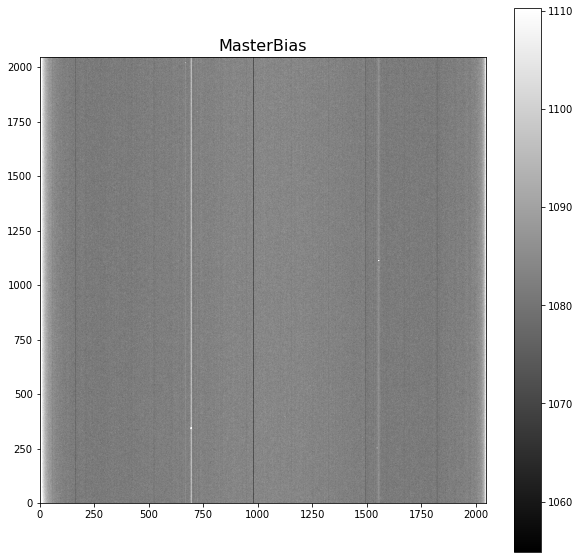

In [8]:
#Ahora vamos a cargar la imágen y la vamos a ver para revisar que no
#haya ningún problema. 
desplegar_imagen("wasp43_red/MasterBias.fits", titulo="MasterBias")

#### b) Dark

Además de los problemas de lectura evidenciados por el bias, las cámara CCD también tienen un problema que se le llama *corriente oscura*. La corriente oscura (o *dark current* in inglés) consiste en electrones que aleatoriamente entran a los pixeles sin corresponder a un fotón, y dependen de cuánto tiempo de exposición tengan las imágenes. 

Nuestra imagen de calibración, a la que llamaremos **Dark**, será generada combinando 10 imágenes de calibración obtenidas inmediatamente después de las observaciones de WASP-43. Estas fueron obtenidas usando el mismo tiempo de exposición que las imágenes de ciencia, es decir, 120 segundos, pero sin abrir el obturador. Como no se abrió el obturador de la cámara, sabemos que todos los electrones detectados, entonces, corresponden a la corriente oscura de la cámara y no a fotones reales. Dado que estas imágenes de calibración también van a tener problemas de lectura, al igual que todas las imágenes tomadas por esta cámara, vamos a necesitar el Bias generado en el paso anterior para corregir nuestras imágenes de corriente oscura. 

In [9]:
#Esta instrucción genera una lista de los nombres de las imágenes de Dark 
#que vamos a combinar.
imagenes_dark = []
for i in range(45,55):
    imagenes_dark.append("{0:08d}.Dark.fit".format(i))
print(imagenes_dark)

['00000045.Dark.fit', '00000046.Dark.fit', '00000047.Dark.fit', '00000048.Dark.fit', '00000049.Dark.fit', '00000050.Dark.fit', '00000051.Dark.fit', '00000052.Dark.fit', '00000053.Dark.fit', '00000054.Dark.fit']


In [10]:
crear_masterdark(imagenes_dark, nombre_dark="MasterDark.fits",
                 nombre_bias="MasterBias.fits",
                 directorio_imagenes_originales="wasp43_raw", 
                 directorio_imagenes_reducidas="wasp43_red")

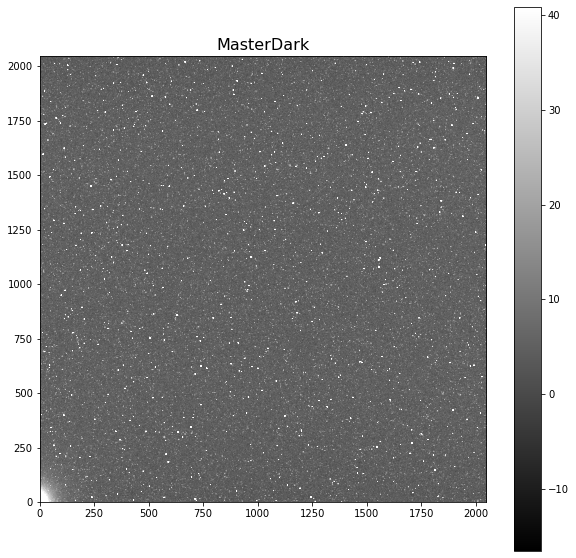

In [11]:
#Ahora vamos a cargar la imágen y la vamos a ver para revisar que no
#haya ningún problema.
desplegar_imagen("wasp43_red/MasterDark.fits", titulo='MasterDark')

#### c) Flat

La última imágen de calibración que vamos a necesitar es aquella a la que llamamos **Flat**, que corresponde a una imágen de una zona intrínsecamente uniforme, de tal manera que las diferencias entre los pixeles representan diferencias de sensibilidad entre los pixeles de la cámara. Estas imágenes de calibración típicamente se obtienen observando el cielo justo después del atardecer, cuando aún hay brillo del Sol, pero el Sol ya está bajo el horizonte. Estas imágenes son sacadas en el mismo filtro en que se hacen las observaciones de ciencia, y necesitan se corregidas por el Bias y el Dark. 

In [12]:
#Esta instrucción genera una lista de los nombres de las imágenes de Flat
#que vamos a combinar.
imagenes_flat = []
for i in range(1,6):
    imagenes_flat.append("FLAT_sloan_r_B22-{0:03d}.fit".format(i))
print(imagenes_flat)

['FLAT_sloan_r_B22-001.fit', 'FLAT_sloan_r_B22-002.fit', 'FLAT_sloan_r_B22-003.fit', 'FLAT_sloan_r_B22-004.fit', 'FLAT_sloan_r_B22-005.fit']


In [13]:
crear_masterflat(imagenes_flat, 
                 nombre_flat="MasterFlat.fits",
                 nombre_dark="MasterDark.fits",
                 nombre_bias="MasterBias.fits",
                 directorio_imagenes_originales="wasp43_raw",
                 directorio_imagenes_reducidas="wasp43_red")

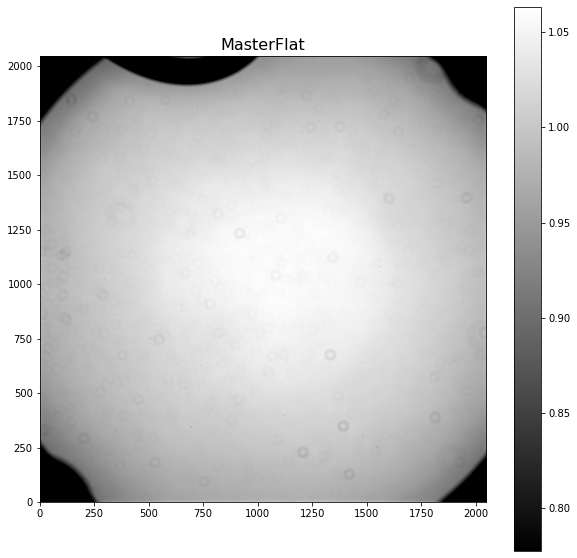

In [14]:
#Ahora vamos a cargar la imágen y la vamos a ver para revisar que no
#haya ningún problema.
desplegar_imagen("wasp43_red/MasterFlat.fits", titulo='MasterFlat')

#### d) Reducción de las imágenes de Ciencia

Usando nuestras tres imágenes de calibración, **Bias**, **Dark** y **Flat**, vamos a corregir las imperfecciones de la cámara en todas nuestras imágenes de ciencia. Además, vamos a aplicar una rutina de corrección de rayos cósmicos, que son electrones que viajan por el ambiente y quedan atrapados en los pixeles de la cámara. 

In [15]:
#Esta instrucción genera una lista de los nombres de las imágenes de ciencia 
#que vamos a reducir.
imagenes_ciencia = []
for i in range(4,45):
    imagenes_ciencia.append("{0:08d}.fit".format(i))
print(imagenes_ciencia)

['00000004.fit', '00000005.fit', '00000006.fit', '00000007.fit', '00000008.fit', '00000009.fit', '00000010.fit', '00000011.fit', '00000012.fit', '00000013.fit', '00000014.fit', '00000015.fit', '00000016.fit', '00000017.fit', '00000018.fit', '00000019.fit', '00000020.fit', '00000021.fit', '00000022.fit', '00000023.fit', '00000024.fit', '00000025.fit', '00000026.fit', '00000027.fit', '00000028.fit', '00000029.fit', '00000030.fit', '00000031.fit', '00000032.fit', '00000033.fit', '00000034.fit', '00000035.fit', '00000036.fit', '00000037.fit', '00000038.fit', '00000039.fit', '00000040.fit', '00000041.fit', '00000042.fit', '00000043.fit', '00000044.fit']


In [16]:
reducir_imagenes_ciencia(imagenes_ciencia, prefijo="ciencia",
                         reyeccion_rayos_cosmicos=True,
                         nombre_flat="MasterFlat.fits",
                         nombre_dark="MasterDark.fits",
                         nombre_bias="MasterBias.fits",
                         directorio_imagenes_originales="wasp43_raw", 
                         directorio_imagenes_reducidas="wasp43_red")

#### e) Alineación de las imágenes de Ciencia (**Nuevo**)

El último paso que vamos a aplicar a la corrección consiste en la alineación de las imágenes de ciencia para que las estrellas estén en la misma posición en todas las imágenes.

In [17]:
#Esta instrucción genera una lista de los nombres de las imágenes de ciencia reducida que vamos a alinear.
imagenes_ciencia_reducidas = []
for i in range(4,45):
    imagenes_ciencia_reducidas.append("ciencia_{0:08d}.fit".format(i))
print(imagenes_ciencia_reducidas)

['ciencia_00000004.fit', 'ciencia_00000005.fit', 'ciencia_00000006.fit', 'ciencia_00000007.fit', 'ciencia_00000008.fit', 'ciencia_00000009.fit', 'ciencia_00000010.fit', 'ciencia_00000011.fit', 'ciencia_00000012.fit', 'ciencia_00000013.fit', 'ciencia_00000014.fit', 'ciencia_00000015.fit', 'ciencia_00000016.fit', 'ciencia_00000017.fit', 'ciencia_00000018.fit', 'ciencia_00000019.fit', 'ciencia_00000020.fit', 'ciencia_00000021.fit', 'ciencia_00000022.fit', 'ciencia_00000023.fit', 'ciencia_00000024.fit', 'ciencia_00000025.fit', 'ciencia_00000026.fit', 'ciencia_00000027.fit', 'ciencia_00000028.fit', 'ciencia_00000029.fit', 'ciencia_00000030.fit', 'ciencia_00000031.fit', 'ciencia_00000032.fit', 'ciencia_00000033.fit', 'ciencia_00000034.fit', 'ciencia_00000035.fit', 'ciencia_00000036.fit', 'ciencia_00000037.fit', 'ciencia_00000038.fit', 'ciencia_00000039.fit', 'ciencia_00000040.fit', 'ciencia_00000041.fit', 'ciencia_00000042.fit', 'ciencia_00000043.fit', 'ciencia_00000044.fit']


In [18]:
alinear_imagenes_ciencia(imagenes_ciencia_reducidas, prefijo='ali',
                         directorio_imagenes_reducidas="wasp43_red")

Para comparara los efectos de estas correcciones, vamos a ver una imagen antes y después de realizar todas las correcciones. 

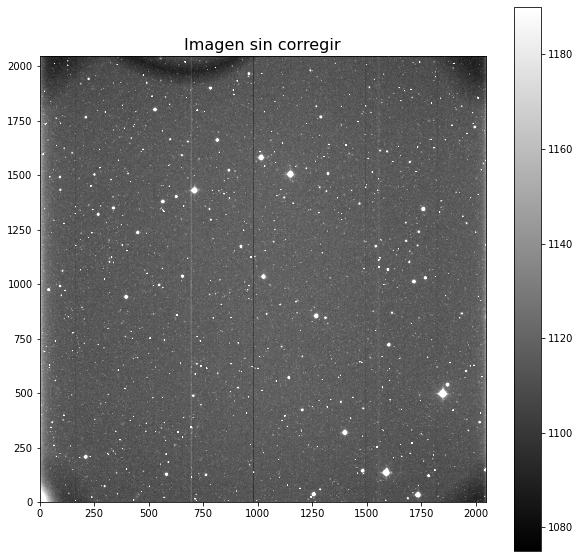

In [19]:
desplegar_imagen("wasp43_raw/00000005.fit", titulo='Imagen sin corregir',
                 cmin=1075, cmax=1190)

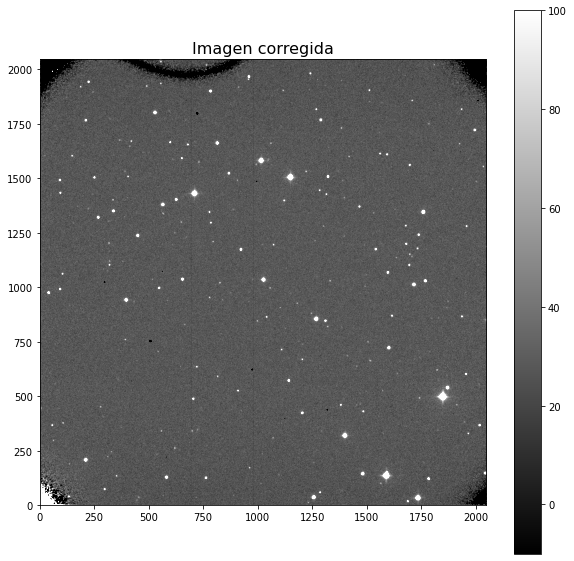

In [20]:
desplegar_imagen("wasp43_red/ali_ciencia_00000005.fit", titulo='Imagen corregida',
                 cmin=-10, cmax=100)

## Parte 2 - Fotometría

Una vez que tenemos todas las imágenes reducidas, vamos a medir la fotometría. La fotometría significa medir el número de fotones provenientes de una fuente (e.g., estrella o galaxia) detectados por la cámara. En la práctica, lo que haremos es usar un algoritmo automatizado para encontrar todas las fuentes luminosas en las imágenes, y luego haremos fotometría de apertura en cada fuente. 

La fotometría de apertura consiste en poner un circulo (o **apertura**) centrada en la fuente con un cierto radio, y contar cuántos fotones (electrones en realidad, pero para todos los efectos prácticos es lo mismo) hay dentro de la apertura. Esos fotones corresponderán a los que vienen de la estrella o galaxia más los fotones que vienen del brillo del cielo (una mezcla de luz difusa que viene de la Luna y de la polución lumínica de las ciudades comúnmente). 

Para restar los fotones del cielo podemos usar dos técnicas comúnes. La primera es generando una imágen del cielo y que es la que vamos a usar. Se genera usando un proceso eliminación de las estrellas y difuminando el resto de la imagen para estimar el nivel medio de la contribución del cielo. La seguna opción es usando un anillo alrededor de la fuente y asumiendo que el brillo promedio del cielo en ese anillo es el mismo que en la apertura. 

La rutina [medir_fotometria](transitos_dha1001/fotometria/phot.py) puede hacer ambas cosas. En este ejercicio usaremos solo la primera forma, pero vea la documentación de la rutina para ver cómo realizar la estimación del cielo usando anillos usando el comando

```python
help(medir_fotometria)
```

el cual mostrará una breve descripción de todos los parámetros disponibles para la función. Note que con este mismo comando puede acceder a la documentación de cualquiera de las funciones.

#### a) Encontrar las fuentes en la Imagen de Referencia

Primero vamos a encontrar todas las fuentes en una sola imagen, que le llamaremos la imagen de referencia. Por simpleza, usaremos la primera imagen como la imagen de referencia.

Para no tener problemas con los bordes de la imagen, vamos a solo usar fuentes lejos de los bordes. 

In [21]:
posiciones_referencia = dao_busqueda("ali_ciencia_00000004.fit",
                                     directorio_imagenes_reducidas="wasp43_red",
                                     directorio_fotometria="wasp43_fot")

Buscando fuentes en la imagen  ali_ciencia_00000004.fit


#### b) Encontrar las fuentes en el resto de las imágenes

Para el resto de las imágenes, vamos a partir de las posiciones de todas las fuentes encontradas en la imagen de referencia, y las vamos a recentrar. Dado que todas las imagenes fueron sacadas en un periodo corto de tiempo y la posición no varía mucho entre imágenes, podemos hacer esto. Si el telescopio se hubiese movido más y las estrellas cambiaran mucho de posición, tendríamos que usar técnicas de alineación más sofisticadas. Por suerte, este no es el caso acá. 

In [22]:
imagenes_reducidas_alineadas = []
for i in range(4,45):
    imagenes_reducidas_alineadas.append("ali_ciencia_{0:08d}.fit".format(i))
print(imagenes_reducidas_alineadas)

['ali_ciencia_00000004.fit', 'ali_ciencia_00000005.fit', 'ali_ciencia_00000006.fit', 'ali_ciencia_00000007.fit', 'ali_ciencia_00000008.fit', 'ali_ciencia_00000009.fit', 'ali_ciencia_00000010.fit', 'ali_ciencia_00000011.fit', 'ali_ciencia_00000012.fit', 'ali_ciencia_00000013.fit', 'ali_ciencia_00000014.fit', 'ali_ciencia_00000015.fit', 'ali_ciencia_00000016.fit', 'ali_ciencia_00000017.fit', 'ali_ciencia_00000018.fit', 'ali_ciencia_00000019.fit', 'ali_ciencia_00000020.fit', 'ali_ciencia_00000021.fit', 'ali_ciencia_00000022.fit', 'ali_ciencia_00000023.fit', 'ali_ciencia_00000024.fit', 'ali_ciencia_00000025.fit', 'ali_ciencia_00000026.fit', 'ali_ciencia_00000027.fit', 'ali_ciencia_00000028.fit', 'ali_ciencia_00000029.fit', 'ali_ciencia_00000030.fit', 'ali_ciencia_00000031.fit', 'ali_ciencia_00000032.fit', 'ali_ciencia_00000033.fit', 'ali_ciencia_00000034.fit', 'ali_ciencia_00000035.fit', 'ali_ciencia_00000036.fit', 'ali_ciencia_00000037.fit', 'ali_ciencia_00000038.fit', 'ali_ciencia_000000

In [23]:
for imagen in imagenes_reducidas_alineadas[1:]:
    _ = dao_recentrar(imagen,
                      posiciones_referencia, 
                      directorio_imagenes_reducidas="wasp43_red",
                      directorio_fotometria="wasp43_fot", 
                      caja_busqueda=21)

Recentrando fuentes en la imagen ali_ciencia_00000005.fit
Recentrando fuentes en la imagen ali_ciencia_00000006.fit
Recentrando fuentes en la imagen ali_ciencia_00000007.fit
Recentrando fuentes en la imagen ali_ciencia_00000008.fit
Recentrando fuentes en la imagen ali_ciencia_00000009.fit
Recentrando fuentes en la imagen ali_ciencia_00000010.fit
Recentrando fuentes en la imagen ali_ciencia_00000011.fit
Recentrando fuentes en la imagen ali_ciencia_00000012.fit
Recentrando fuentes en la imagen ali_ciencia_00000013.fit
Recentrando fuentes en la imagen ali_ciencia_00000014.fit
Recentrando fuentes en la imagen ali_ciencia_00000015.fit
Recentrando fuentes en la imagen ali_ciencia_00000016.fit
Recentrando fuentes en la imagen ali_ciencia_00000017.fit
Recentrando fuentes en la imagen ali_ciencia_00000018.fit
Recentrando fuentes en la imagen ali_ciencia_00000019.fit
Recentrando fuentes en la imagen ali_ciencia_00000020.fit
Recentrando fuentes en la imagen ali_ciencia_00000021.fit
Recentrando fu

#### c) Medir la fotometría de apertura

Finalmente, ahora medimos la fotometría de apertura generando las imagenes del cielo de fondo como se explicó anteriormente. 

Vamos a usar apreturas de 3" (i.e., 3 segundos de arco) de radio. 

In [24]:
for imagen in imagenes_reducidas_alineadas: 
    _, _ = medir_fotometria(imagen, r_ap=3.0,
                     directorio_imagenes_reducidas="wasp43_red",
                     directorio_fotometria="wasp43_fot", 
                     bkg_type='global')

Miremos una de las imagenes de fondo y comparemosla con la imagen reducida para ver que no hay ningún problema.

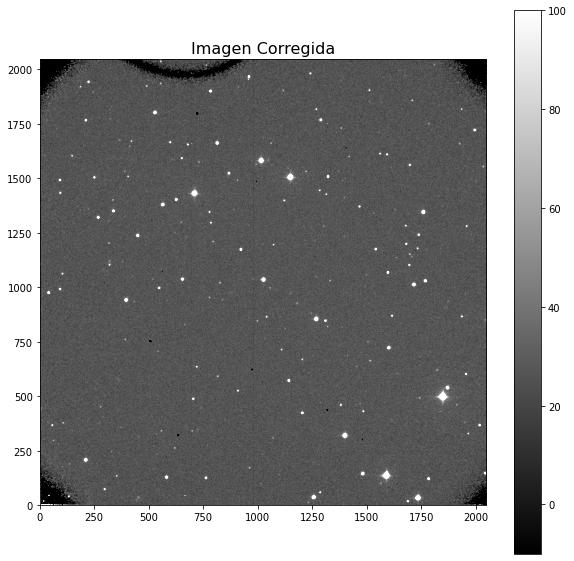

In [25]:
desplegar_imagen("wasp43_red/ali_ciencia_00000010.fit", titulo='Imagen Corregida',
                cmin=-10, cmax=100)

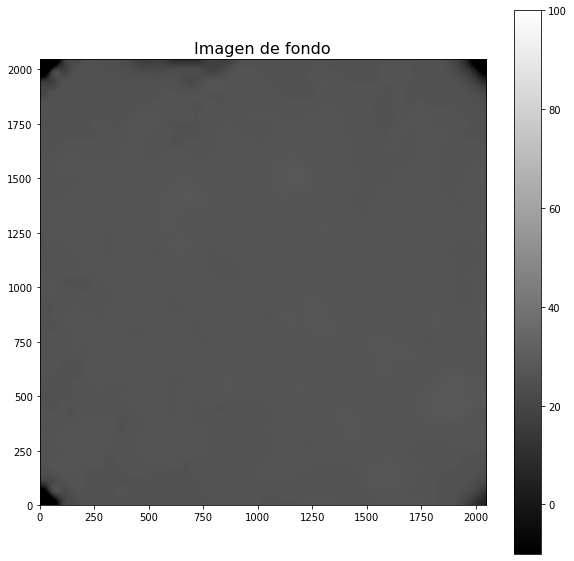

In [26]:
desplegar_imagen("wasp43_red/ali_ciencia_00000010.bkg.fits", titulo='Imagen de fondo',
                 cmin=-10, cmax=100)

## Parte 3 - La Curva de Luz

Finalmente, vamos a querer hacer un gráfico que llamaremos *la curva de luz*, donde veremos el brillo de la estrella WASP-43 como función del tiempo y trataremos de detectar el eclipse causado por su planeta WASP-43b.

Notemos que la estrella WASP-43b es aquella que está aproximadamente en las coordenadas x, y = (1024, 1032) en la imagen de referencia. En caso de necesitar ubicarla en la imagen, usted puede desplegar esa imagen de referencia y puede compararla con una guía visual, comúnmenete llamada en inglés *finding chart*. 

Usted puede obtener, por ejemplo, las coordenadas de Asención Recta (R.A.) y Declinación (Dec.) de WASP-43 usando el servicio [SIMBAD](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=WASP-43), donde encontrarán que son: 

R.A. =  10:19:38.01
Dec. = -09:48:22.6

Y luego puede generar la guía visual, o finding chart, usando un servicio como [IRSA](https://irsa.ipac.caltech.edu/applications/finderchart/?__action=layout.showDropDown&).  

Para generar la curva de luz vamos a usar la rutina [curva_de_luz](transitos_dha1001/fotometria/curva_de_luz.py). Esta rutina pasa por todas las imágenes y extrae el brillo de la fuente solicitada (WASP-43 en este caso). Además, recalibra los brillos asumiendo que todo el resto de las fuentes tienen el mismo brillo en todas las imágenes. 

La rutina nos retorna el momento en que fue tomada la imagen (medida en días Julianos modificados, o *modified Julian date* - [MJD](https://es.wikipedia.org/wiki/Fecha_juliana)), la magnitud instrumental, y el error en la magnitud instrumental. En términos generales, la magnitud se define como:

$mag = -2.5 \log_{10}~ brillo$

donde la definición de brillo fue discutida en clases. 

No conocemos el brillo exacto de la fuente, pero sabemos que su brillo tiene que ser proporcional a la cantidad de fotones detectados por segundo. Considerando esto, definimos la magnitud instrumental como: 

$mag_{Instrumental} = -2.5\ \log_{10}\ Numero\ de\ Fotones\ Detectados\ /\ Tiempo\ de\ exposicion$

donde el tiempo de exposición para estas observaciones es de 120 segundos, como fue mencionado al principio de este cuaderno.

In [27]:
x_wasp43 = 1024
y_wasp43 = 1032
mjd, mag, mag_err = curva_de_luz(imagenes_reducidas_alineadas, 
                                 x_wasp43, y_wasp43, 
                                 directorio_imagenes_reducidas="wasp43_red",
                                 directorio_fotometria="wasp43_fot")

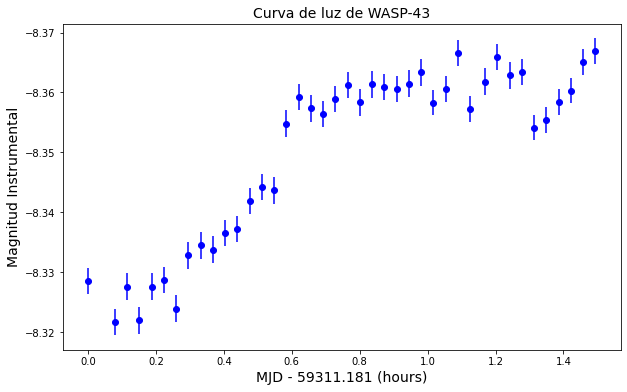

In [28]:
graficar_curva_de_luz(mjd, mag, mag_err, titulo="Curva de luz de WASP-43")